In [1]:
import warnings

warnings.simplefilter("ignore")

from altaipony.lcio import from_mast
import numpy as np
import matplotlib.pyplot as plt

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Find and download the LightCurveFile for your light curve:

In [2]:
flc = from_mast("TIC 29780677", mode="LC", c=2, cadence="short", mission="TESS", author="SPOC")

/home/ekaterina/Documents/000_envs/refactor/lib/python3.6/site-packages/lightkurve/io/tess.py:34: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018234235059-s0002-0000000029780677-0121-s/tess2018234235059-s0002-0000000029780677-0121-s_lc.fits' mode='rb' closefd=True>
  lc = read_generic_lightcurve(filename, flux_column=flux_column, time_format="btjd")
2% (382/18699) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (382/18699) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [3]:
flc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1354.1106148240158,7.0290649e+02,5.7716079e+00,9.8603335e-04,91191,442.01491,466.98605,5.4839716e+02,4.2681370e+00,5.0521918e+02,1.6690421e+00,7.0290649e+02,5.7716079e+00,0,nan,nan,nan,nan,442.01491,4.6820338e-03,466.98605,4.7825403e-03,1.0553836e-02,1.7711492e-03
1354.112003710469,7.0952771e+02,5.7889943e+00,9.8603126e-04,91192,442.00646,467.00012,5.5463330e+02,4.2809939e+00,5.0841406e+02,1.6725917e+00,7.0952771e+02,5.7889943e+00,0,nan,nan,nan,nan,442.00646,4.6342537e-03,467.00012,4.7246478e-03,-7.4736943e-04,1.1154867e-02
1354.1147814836065,6.9482343e+02,5.7644634e+00,9.8602730e-04,91194,442.01789,466.99319,5.4185968e+02,4.2628531e+00,5.0624005e+02,1.6700547e+00,6.9482343e+02,5.7644634e+00,0,nan,nan,nan,nan,442.01789,4.7374149e-03,466.99319,4.8305150e-03,1.4730911e-02,2.2095429e-02
1354.1161703701762,6.9957080e+02,5.7726111e+00,9.8602532e-04,91195,442.00202,466.97744,5.4687842e+02,4.2688789e+00,5.0695230e+02,1.6698010e+00,6.9957080e+02,5.7726111e+00,0,nan,nan,nan,nan,442.00202,4.6638381e-03,466.97744,4.8172241e-03,-1.6149571e-02,-6.8425387e-03
1354.1175592567454,6.9604968e+02,5.7736607e+00,9.8602334e-04,91196,442.00901,466.99402,5.4525580e+02,4.2696548e+00,5.0858142e+02,1.6720915e+00,6.9604968e+02,5.7736607e+00,0,nan,nan,nan,nan,442.00901,4.6817493e-03,466.99402,4.8035197e-03,-1.1917219e-02,5.5444543e-03
1354.1189481433144,6.9314539e+02,5.7680130e+00,9.8602136e-04,91197,442.00552,466.98987,5.4316003e+02,4.2654781e+00,5.0764401e+02,1.6716568e+00,6.9314539e+02,5.7680130e+00,0,nan,nan,nan,nan,442.00552,4.7016251e-03,466.98987,4.8148907e-03,-9.9237645e-03,7.3537691e-03
1354.1203370298833,7.0705133e+02,5.7775888e+00,9.8601938e-04,91198,442.01030,466.99638,5.5360364e+02,4.2725596e+00,5.0341422e+02,1.6705892e+00,7.0705133e+02,5.7775888e+00,0,nan,nan,nan,nan,442.01030,4.6155727e-03,466.99638,4.7412757e-03,-3.7640911e-03,1.4541453e-02
1354.121725916453,6.9229907e+02,5.7592306e+00,9.8601740e-04,91199,442.01878,466.99601,5.4273370e+02,4.2589841e+00,5.0449918e+02,1.6676699e+00,6.9229907e+02,5.7592306e+00,0,nan,nan,nan,nan,442.01878,4.7199707e-03,466.99601,4.7935536e-03,-7.5128525e-03,1.1381662e-02


De-trend the light curve:

In [4]:
flcd = flc.detrend("savgol")

Now you can visually compare the results:

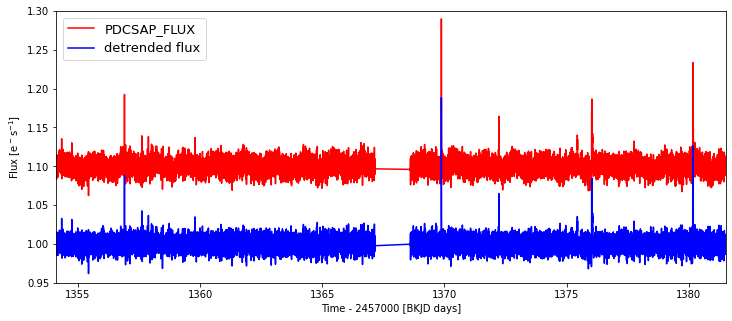

In [5]:
%matplotlib inline
plt.figure(figsize=(12,5))

plt.plot(flcd.time.value, flcd.flux / np.nanmedian(flcd.flux)+0.1, c="r", 
         label="PDCSAP_FLUX")

plt.plot(flcd.time.value, flcd.detrended_flux / np.nanmedian(flcd.detrended_flux),
         "b", label="detrended flux")

plt.xlabel("Time - 2457000 [BKJD days]")
plt.ylabel(r"Flux [e$^-$s$^{-1}$]")
plt.xlim(flcd.time.value[0], flcd.time.value[-1])
plt.ylim(.95,1.30)
plt.legend(loc=2,fontsize=13);

#plt.xlim(1356.7,1357) # not a flare
#plt.xlim(1380,1380.5) # the largest flare
#plt.xlim(1375.8,1376.3) # the second largest flare

The periodicity in the raw light curve disappears in the de-trended one. Outliers and noise is still there.

Where are the flares?

In [6]:
flcd = flcd.find_flares()
flcd.flares.sort_values(by="ed_rec", ascending=False)

Found 0 candidate(s) in the (0,9227) gap.
Found 5 candidate(s) in the (9227,18317) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
4,17387,17403,109949,109965,1380.163272,1380.185494,142.162321,4.002692,0.126814,0.022222,18317.0
2,14495,14513,106969,106987,1376.024417,1376.049417,122.903528,4.062791,0.084867,0.025000,18317.0
0,10142,10147,102541,102546,1369.874451,1369.881395,40.897221,1.685525,0.188604,0.006944,18317.0
3,14520,14524,106995,106999,1376.060528,1376.066084,16.993187,1.964433,0.040135,0.005556,18317.0
1,14085,14088,106547,106550,1375.438310,1375.442477,11.575795,1.708805,0.035673,0.004167,18317.0


Not all visible outliers qualify for flare candidates, because we require a minimum a minimum of three outliers in a row for any candidate. We also apply a set of other criteria, which you can read up on [here in the docs](https://altaipony.readthedocs.io/en/latest/tutorials/altai.html).

What did the de-trending do to the flare candidates and their properties? 

Let's find out and try to find flares in the raw light curve.

In [7]:
flc.detrended_flux = flc.flux
flc.detrended_flux_err = flc.flux_err
flc = flc.find_flares()
flc.flares.sort_values(by="ed_rec", ascending=False)

Found 1 candidate(s) in the (0,9227) gap.
Found 5 candidate(s) in the (9227,18317) gap.


,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
5,17387,17404,109949,109966,1380.163272,1380.186883,159.239757,4.119445,0.133967,0.023611,18317.0
3,14495,14513,106969,106987,1376.024417,1376.049417,127.508457,4.073077,0.086997,0.025000,18317.0
1,10142,10147,102541,102546,1369.874451,1369.881395,41.839981,1.702053,0.190166,0.006944,18317.0
0,1982,1985,93203,93206,1356.905057,1356.909224,19.583386,1.529734,0.092272,0.004167,18317.0
4,14520,14524,106995,106999,1376.060528,1376.066084,18.017254,1.966022,0.042268,0.005556,18317.0
2,14085,14088,106547,106550,1375.438310,1375.442477,13.331994,1.710031,0.040551,0.004167,18317.0


The large flares appear larger, and there is a small extra candidate. The former is because these flares occur when the stellar variability adds flux to the flare. If no de-trending occurs, variability is not accounted for. The extra flare will not be recognized as such in the de-trended light curve because it will not stick out enough (above 3 sigma level) from the quiescent flux.

But there is likely also an effect introduced by the de-trending algorithm itself. Here is where injection-recovery comes in:

In [8]:
flcd, fakeflc = flcd.sample_flare_recovery(inject_before_detrending=True, mode="savgol", 
                                          iterations=50, fakefreq=1, ampl=[1e-4, 0.5],
                                           dur=[.001/6., 0.1/6.]
                                          )

N/A%|                                                                         |
Detrending fake LC:

Found 12 candidate(s) in the (0,9227) gap.
Found 17 candidate(s) in the (9227,18317) gap.
  2%|#                                                                        |
Detrending fake LC:

Found 10 candidate(s) in the (0,9227) gap.
Found 14 candidate(s) in the (9227,18317) gap.
  4%|##                                                                       |
Detrending fake LC:

Found 12 candidate(s) in the (0,9227) gap.
Found 14 candidate(s) in the (9227,18317) gap.
  6%|####                                                                     |
Detrending fake LC:

Found 11 candidate(s) in the (0,9227) gap.
Found 15 candidate(s) in the (9227,18317) gap.
  8%|#####                                                                    |
Detrending fake LC:

Found 12 candidate(s) in the (0,9227) gap.
Found 15 candidate(s) in the (9227,18317) gap.
 10%|#######                                 

 86%|##############################################################           |
Detrending fake LC:

Found 9 candidate(s) in the (0,9227) gap.
Found 13 candidate(s) in the (9227,18317) gap.
 88%|################################################################         |
Detrending fake LC:

Found 15 candidate(s) in the (0,9227) gap.
Found 17 candidate(s) in the (9227,18317) gap.
 90%|#################################################################        |
Detrending fake LC:

Found 12 candidate(s) in the (0,9227) gap.
Found 16 candidate(s) in the (9227,18317) gap.
 92%|###################################################################      |
Detrending fake LC:

Found 13 candidate(s) in the (0,9227) gap.
Found 15 candidate(s) in the (9227,18317) gap.
 94%|####################################################################     |
Detrending fake LC:

Found 10 candidate(s) in the (0,9227) gap.
Found 19 candidate(s) in the (9227,18317) gap.
 96%|#########################################

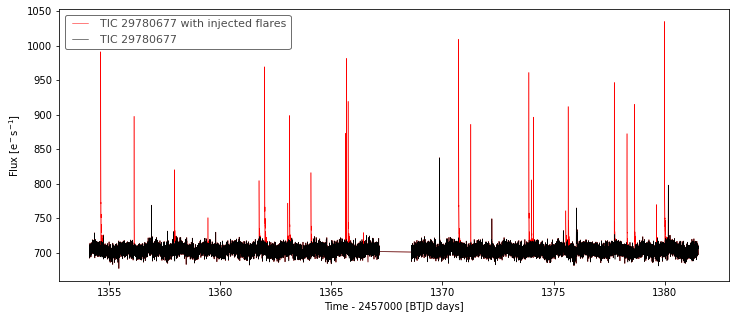

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
fakeflc.plot(ax=ax,c="r", label="TIC 29780677 with injected flares")
flcd.plot(ax=ax,c="k");

In [10]:
print("The total number of injected flares is {}.".format(flcd.fake_flares.shape[0]))
print("Choose the bins below such that the number in each ampl-dur bin is >10 on average.")

The total number of injected flares is 1350.
Choose the bins below such that the number in each ampl-dur bin is >10 on average.


In [11]:
flcc = flcd.characterize_flares(ampl_bins=10, dur_bins=10) 

In [12]:
flcc.flares[["dur", "ampl_rec","ed_rec","tstart",
             "ed_ratio","recovery_probability",
             "ed_ratio_count","recovery_probability_std",
             "ed_corr",]].sort_values(by="ed_rec")

,dur,ampl_rec,ed_rec,tstart,ed_ratio,recovery_probability,ed_ratio_count,recovery_probability_std,ed_corr
1,0.004167,0.035673,11.575795,1375.438310,0.394910,0.049383,46.0,0.218016,29.312483
3,0.005556,0.040135,16.993187,1376.060528,0.394910,0.336957,46.0,0.475260,43.030522
0,0.006944,0.188604,40.897221,1369.874451,0.751078,0.724490,31.0,0.449068,54.451371
2,0.025000,0.084867,122.903528,1376.024417,0.616322,0.986842,14.0,0.114708,199.414574
4,0.022222,0.126814,142.162321,1380.163272,0.616322,0.987952,14.0,0.109764,230.662529


Depending on the statistics of the injected flares, the middle sized flare may not have been captured by the injection recovery grid (or only with a small number in `ed_ratio_count`). 

We can solve this by increasing either the number of iterations in `sample_flare_recovery` or changing the range of amplitudes and durations injected, or both. But the latter is difficult to know a priori because we do not know how recovered amplitudes and durations map to injected ones. You will have to tinker with the parameters at the moment, like `dur` and `ampl` in sample flare_recovery, or `ampl_bins` and `dur_bins` in `characterize_flares`. 

A cross-check for the quality of the values for ED ratio (`ed_ratio`) and recovery probability (`recovery_probability`) are the respective counts, that is the number of synthetic flares that exhibit the true and recovered characteristics. Usually, ~100 events in a bin is a good heuristic. But you should also check the `_std` values for the intristic scatter in `ed_corr` and `recovery_probability`. The latter will show that the uncertainty on recovery probability for the small flares is ~.4, which you may choose as criterion for excluding this candidate from the results. 

Caution: low number in `ed_ratio_count` may also mean that the recovery probability at these energies is just low, especially when `ed_rec` is small.





Questions? Something does not work? Email me @ eilin@aip.de 